# Classification and Clustering : Practicing with real data

In this lab, we consider the 20 newsgroups text dataset from [scikit-learn](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).

In [2]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint

# Training set
cats = ['rec.sport.baseball', 'sci.electronics', 'misc.forsale']
train_data = fetch_20newsgroups(subset='train', categories=cats)

## Getting to know your data

In [3]:
print(train_data.target, len(train_data.target))
print(train_data.target[0:10])
print(train_data.target_names)

[0 0 0 ..., 2 0 2] 1773
[0 0 0 1 2 1 2 2 2 1]
['misc.forsale', 'rec.sport.baseball', 'sci.electronics']


In [5]:
print(train_data.target_names[train_data.target[0]])
print()
print(train_data.data[0])

misc.forsale

From: jrwaters@eos.ncsu.edu (JACK ROGERS WATERS)
Subject: Portable Color Television For Sale
Organization: North Carolina State University, Project Eos
Lines: 17


Hello Everyone,

    I have a Casio TV-470 LCD Color Television for sale.  It
is in mint condition.  Retail is $199 but I'm looking to
get about 1/2 of that for it, tops.  Highest bidder in 
a week gets it, assuming the highest bidder is at least $60.

TV comes with black case and uses 4 AA batteries.  They also
sell AC adaptor.  It has external jack for phones and external
antenna, etc.  The picture is very good and it has electronic
tuning so you don't have to screw with tuning a picture in, etc.
I have the box and all documentation.  This has seen less than
3 hours use as I have all but sworn off TV.

Best Regards
Jack Waters II



### Data Preprocessing

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency. This is a originally a term weighting scheme developed for information retrieval (as a ranking function for search engines results), that has also found good use in document classification and clustering.

$$\text{tf}(t,d) = \text{Number of times term }t \text{ occurs in document } d$$

If $N$ is the total number of documents in the corpus $D$ then

$$\text{idf}(t,D)=\frac{N}{|\{d\in D\mid t\in d \}|}$$

$$\text{tf-idf}(t,d)=\text{tf}(t,d)\times \text{idf}(t,D)$$

TF-IDF for text documents :  http://scikit-learn.org/stable/modules/feature_extraction.html

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.01, max_df=0.8)
text_train_data = vectorizer.fit_transform(train_data.data)

Explain each parameter from [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [5]:
print(len(train_data.data))
print(text_train_data.shape)

1773
(1773, 1564)


## Clustering

Use clustering techniques to identify groups in this dataset. You have to assume that the number of groups is unkown. Compare the results with the known groups.

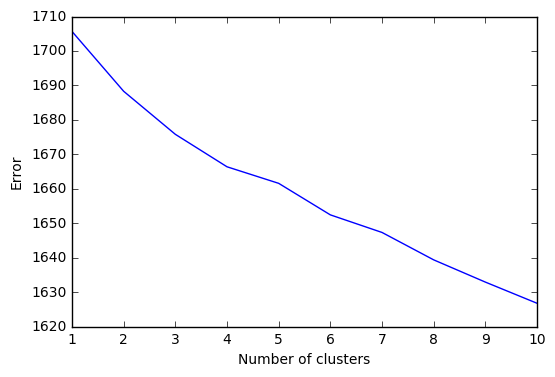

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline

def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=3)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(text_train_data, 10)

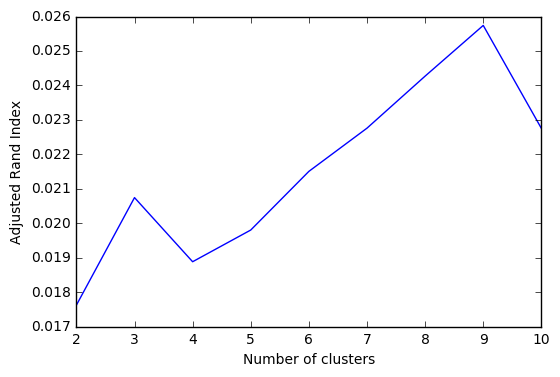

In [12]:
import sklearn.metrics as metrics

def sc_evaluate_clusters(X, max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    
sc_evaluate_clusters(text_train_data,10)

In [24]:
# ...
from sklearn.cluster import KMeans
k = 9
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
clusters = kmeans.fit_predict(text_train_data)

In [83]:
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()

Top terms per cluster:
Cluster 0:
 edu
 ca
 like
 good
 don
 university
 cs
 year
 10
 new

Cluster 1:
 edu
 university
 host
 posting
 nntp
 sale
 article
 distribution
 writes
 usa

Cluster 2:
 com
 article
 writes
 sale
 edu
 does
 distribution
 use
 posting
 know



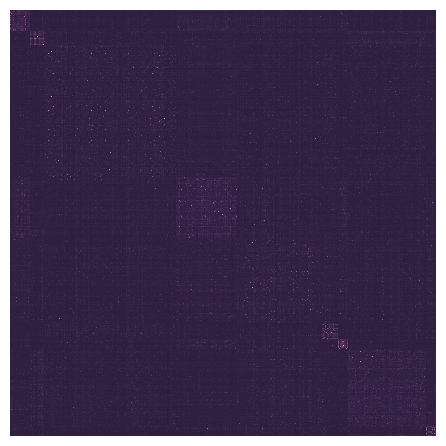

In [25]:
import seaborn as sns
euclidean_dists = metrics.euclidean_distances(text_train_data)
idx = np.argsort(kmeans.labels_)
rearranged_dists = euclidean_dists[idx,:][:,idx]
sns.heatmap(rearranged_dists, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

In [26]:
import numpy as np

for n_clusters in range(k):
    print(np.bincount(train_data.target[np.where(clusters == n_clusters)]))

[ 7 72  7]
[49  8]
[ 99  45 405]
[  1 254]
[ 85 155 113]
[ 5  6 57]
[ 0 42]
[314   2   5]
[25 13  4]


## Classification

Build two classifiers (decision tree and naive bayes) that are able to predict the category of a given message. 

In [15]:
from sklearn.naive_bayes import MultinomialNB

classifier_mnd = MultinomialNB().fit(text_train_data, train_data.target)

y_pred = classifier_mnd.predict(text_train_data)

print("Number of mislabeled points out of a total %d points : %d" 
       % (text_train_data.shape[0],(train_data.target != y_pred).sum()))



Number of mislabeled points out of a total 1773 points : 64


In [16]:
from sklearn import tree

classifier_dt = tree.DecisionTreeClassifier().fit(text_train_data, train_data.target)

y_pred = classifier_dt.predict(text_train_data)

print("Number of mislabeled points out of a total %d points : %d" 
       % (text_train_data.shape[0],(train_data.target != y_pred).sum()))

Number of mislabeled points out of a total 1773 points : 0


Compare the performance of these two classifiers with respect to the test set.

In [19]:
test_data = fetch_20newsgroups(subset='test', categories=cats)
text_test_data = vectorizer.transform(test_data.data)

y_pred = classifier_dt.predict(text_train_data)

print("Number of mislabeled points out of a total %d points (Train) : %d" 
      % (text_train_data.shape[0],(train_data.target != y_pred).sum()))

y_pred = classifier_dt.predict(text_test_data)

print("Number of mislabeled points out of a total %d points (Test) : %d" 
      % (text_test_data.shape[0],(test_data.target != y_pred).sum()))

Number of mislabeled points out of a total 1773 points (Train) : 0
Number of mislabeled points out of a total 1180 points (Test) : 221
